<a href="https://colab.research.google.com/github/JamionW/Advanced-Analysis-of-Algorithms/blob/master/Combinatorial_Inverse_Elasticity_A_Star_POC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
import pyproj
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points, transform
import numpy as np
import fiona
import geopandas as gpd
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from functools import lru_cache

### Dataset Imports

In [2]:
# ADDRESSES

# Read in addresses
# this takes about 20 minutes for the State of Tennessee
# less than a minute for Chattanooga

# Read the GeoJSON file into a GeoDataFrame
#address_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/tennessee.geojson')

# Chattanooga, for testing
address_df = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/data/chattanooga.geojson')

In [3]:
#SVI

gdb_file = "/content/drive/MyDrive/Colab Notebooks/data/SVI2022_TENNESSEE_tract.gdb"

#layers = fiona.listlayers(gdb_file)
#print(layers)

svi_df = gpd.read_file(gdb_file, layer='SVI2022_TENNESSEE_tract')

In [4]:
# ROADS

# Import shapefiles
# https://www.census.gov/cgi-bin/geo/shapefiles/index.php

# documentation here: https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2023/TGRSHP2023_TechDoc.pdf

# Open the shapefile as a Fiona collection
with fiona.open('/content/drive/MyDrive/Colab Notebooks/data/tl_2023_47065_roads.shp') as collection:
    # Create a GeoDataFrame from the collection
    roads_df = gpd.GeoDataFrame.from_features(collection)

In [5]:
# Ensure all data is in the same CRS
target_crs = "EPSG:32618"  # UTM zone 18N
roads_df = roads_df.set_crs(target_crs)
address_df = address_df.to_crs(target_crs)
svi_df = svi_df.to_crs(target_crs)

### Graph Creation

In [6]:
def create_graph_from_roads(roads_gdf):
    G = nx.Graph()
    for idx, row in roads_gdf.iterrows():
        if row.geometry.geom_type == 'LineString':
            start = row.geometry.coords[0]
            end = row.geometry.coords[-1]
            G.add_edge(start, end, geometry=row.geometry, length=row.geometry.length)
        elif row.geometry.geom_type == 'MultiLineString':
            for line in row.geometry:
                start = line.coords[0]
                end = line.coords[-1]
                G.add_edge(start, end, geometry=line, length=line.length)
    return G

G = create_graph_from_roads(roads_df)

In [7]:
# Add edge lengths if missing
for u, v, data in G.edges(data=True):
    if 'length' not in data:
        data['length'] = np.sqrt((G.nodes[u]['pos'][0] - G.nodes[v]['pos'][0])**2 +
                                 (G.nodes[u]['pos'][1] - G.nodes[v]['pos'][1])**2)

In [8]:
# Define the transformation
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:32618')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform

# Project the graph
G_projected = G.copy()
for node in G_projected.nodes():
    point = transform(project, Point(node))
    G_projected.nodes[node]['pos'] = (point.x, point.y)

for u, v, data in G_projected.edges(data=True):
    point1 = Point(G_projected.nodes[u]['pos'])
    point2 = Point(G_projected.nodes[v]['pos'])
    data['length'] = point1.distance(point2)

# Use G_projected instead of G in calculations from this point on

# Euclidean Elasticity with Decay

In [9]:
def calculate_euclidean_inverse_elasticity(target_area_data, point_gdf, area_index_gdf, lambda_param=0.001, beta=1, index_column='RPL_THEMES', area_id_column='FIPS'):
    print("Starting calculate_euclidean_inverse_elasticity")
    print(f"Points in point_gdf: {len(point_gdf)}")

    target_geometry = target_area_data.geometry
    print(f"Target area size: {target_geometry.area}")

    # Get points within the target area
    points_within = point_gdf[point_gdf.geometry.within(target_geometry)]
    print(f"Points within target area: {len(points_within)}")

    # Find neighboring areas
    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]
    print(f"Number of neighboring areas: {len(neighboring_areas)}")

    results = []
    for _, point in points_within.iterrows():
        point_geom = point.geometry if hasattr(point, 'geometry') else point['geometry']
        point_id = point.Index if hasattr(point, 'Index') else (point.name if hasattr(point, 'name') else point['id'])

        for _, neighbor_area in neighboring_areas.iterrows():
            # Find the nearest point on the neighboring area to the point
            nearest_point = nearest_points(point_geom, neighbor_area.geometry)[1]

            # Calculate Euclidean distance
            distance = point_geom.distance(nearest_point)

            # Calculate index difference
            target_index = target_area_data[index_column]
            neighbor_index = neighbor_area[index_column]
            index_difference = abs(target_index - neighbor_index)

            # Calculate inverse elasticity using exponential decay
            if index_difference == 0:
                inverse_elasticity = float('inf')
            else:
                inverse_elasticity = np.exp(-lambda_param * distance) / (index_difference ** beta)

            results.append({
                'target_area': target_area_data[area_id_column],
                'point_id': point_id,
                'neighbor_area': neighbor_area[area_id_column],
                'distance_euclidean': distance,
                'inverse_elasticity_euclidean': inverse_elasticity
            })

    print(f"Total results calculated: {len(results)}")
    return pd.DataFrame(results)

### Network Elasticity with Decay

In [18]:
def calculate_network_inverse_elasticity(G, target_area_data, point_gdf, area_index_gdf, euclidean_results, lambda_param=0.001, beta=1, index_column='RPL_THEMES', area_id_column='FIPS'):
    print("Starting calculate_network_inverse_elasticity")
    target_geometry = target_area_data.geometry
    points_within = point_gdf[point_gdf.geometry.within(target_geometry)]
    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_geometry)]

    print(f"Points within target area: {len(points_within)}")
    print(f"Number of neighboring areas: {len(neighboring_areas)}")

    # Create spatial index for graph nodes
    node_coords = np.array([(data['pos'][0], data['pos'][1]) for _, data in G.nodes(data=True)])
    node_tree = cKDTree(node_coords)

    def find_nearest_node(point):
        _, index = node_tree.query([point.x, point.y])
        return list(G.nodes())[index]

    # Preprocess Euclidean distances into a dictionary for faster lookup
    euclidean_distances = {
        (row['point_id'], row['neighbor_area']): row['distance_euclidean']
        for _, row in euclidean_results.iterrows()
    }

    def process_point(row):
        results = []
        point_geom = row.geometry if hasattr(row, 'geometry') else row['geometry']
        point_id = row.Index if hasattr(row, 'Index') else (row.name if hasattr(row, 'name') else row['id'])
        point_node = find_nearest_node(point_geom)

        for _, neighbor_area in neighboring_areas.iterrows():
            nearest_point_on_neighbor = nearest_points(point_geom, neighbor_area.geometry)[1]
            neighbor_node = find_nearest_node(nearest_point_on_neighbor)

            try:
                euclidean_distance = euclidean_distances[(point_id, neighbor_area[area_id_column])]
                heuristic = lambda u, v: euclidean_distance
                network_distance = nx.astar_path_length(G, point_node, neighbor_node, heuristic, weight='length')

                index_difference = abs(target_area_data[index_column] - neighbor_area[index_column])

                if index_difference == 0:
                    inverse_elasticity = float('inf')
                else:
                    inverse_elasticity = np.exp(-lambda_param * network_distance) / (index_difference ** beta)

                results.append({
                    'target_area': target_area_data[area_id_column],
                    'point_id': point_id,
                    'neighbor_area': neighbor_area[area_id_column],
                    'network_distance': network_distance,
                    'inverse_elasticity_network': inverse_elasticity
                })
            except nx.NetworkXNoPath:
                continue

        return results

    # Use parallel processing
    all_results = Parallel(n_jobs=-1)(delayed(process_point)(row) for row in points_within.itertuples())

    flattened_results = [item for sublist in all_results for item in sublist]
    print(f"Total results calculated: {len(flattened_results)}")

    return pd.DataFrame(flattened_results)

#Combine Elasticities

In [19]:
def combine_elasticities_and_calculate_weighted_index(network_df, euclidean_df, area_index_gdf, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    # Merge the two DataFrames
    combined_df = pd.merge(network_df, euclidean_df,
                           on=['target_area', 'point_id', 'neighbor_area'])

    # Calculate combined inverse elasticity and distance
    euclidean_weight = 1 - network_weight
    combined_df['combined_inverse_elasticity'] = (
        network_weight * combined_df['inverse_elasticity_network'] +
        euclidean_weight * combined_df['inverse_elasticity_euclidean']
    )
    combined_df['combined_distance'] = (
        network_weight * combined_df['network_distance'] +
        euclidean_weight * combined_df['distance_euclidean']
    )

    # Prepare for weighted index calculation
    target_indices = area_index_gdf.set_index(area_id_column)[index_column]
    combined_df['target_index'] = combined_df['target_area'].map(target_indices)
    combined_df['neighbor_index'] = combined_df['neighbor_area'].map(target_indices)

    # Calculate weights
    grouped = combined_df.groupby('point_id')
    total_weights = grouped['combined_inverse_elasticity'].transform('sum')
    combined_df['weight'] = combined_df['combined_inverse_elasticity'] / total_weights

    # Calculate weighted index
    combined_df['weighted_diff'] = (combined_df['neighbor_index'] - combined_df['target_index']) * combined_df['weight']
    weighted_index_df = grouped.agg({
        'target_area': 'first',
        'target_index': 'first',
        'weighted_diff': 'sum'
    }).reset_index()
    weighted_index_df['weighted_index'] = weighted_index_df['target_index'] + weighted_index_df['weighted_diff']

    return weighted_index_df[['point_id', 'target_area', 'weighted_index']]

#Processing by Tract

In [32]:
def process_target_area(target_area, area_index_gdf, point_gdf, G, lambda_param=0.001, beta=1, network_weight=0.7, index_column='RPL_THEMES', area_id_column='FIPS'):
    print(f"Starting combined process for target area: {target_area}")

    target_area_data = area_index_gdf[area_index_gdf[area_id_column] == target_area].iloc[0]

    # Calculate Euclidean-based inverse elasticity first
    euclidean_result = calculate_euclidean_inverse_elasticity(target_area_data, point_gdf, area_index_gdf, lambda_param, beta, index_column, area_id_column)

    # Calculate network-based inverse elasticity using Euclidean results as heuristics
    network_result = calculate_network_inverse_elasticity(G, target_area_data, point_gdf, area_index_gdf, euclidean_result, lambda_param, beta, index_column, area_id_column)

    # Combine the results and calculate weighted index
    combined_result = combine_elasticities_and_calculate_weighted_index(
        network_result, euclidean_result, area_index_gdf, network_weight, index_column, area_id_column
    )

    print(f"Rows in combined result: {len(combined_result)}")

    return combined_result

#DEBUG

In [31]:
import numpy as np
import pandas as pd

def debug_process_target_area_output(combined_result, target_area, area_index_gdf, point_gdf, index_column='RPL_THEMES', area_id_column='FIPS'):
    debug_info = []

    def append_info(section, content):
        debug_info.append(f"\n{section}")
        debug_info.append(content)

    # Get the target area data
    target_area_data = area_index_gdf[area_index_gdf[area_id_column] == target_area].iloc[0]

    # 1. Check Combined results
    append_info("1. Combined Results:",
                f"Shape: {combined_result.shape}\n"
                f"Null counts:\n{combined_result.isnull().sum()}\n"
                f"Unique point_ids: {combined_result['point_id'].nunique()}")

    # 2. Check expected vs actual results
    points_within = point_gdf[point_gdf.geometry.within(target_area_data.geometry)]
    neighboring_areas = area_index_gdf[area_index_gdf.geometry.touches(target_area_data.geometry)]
    expected_rows = len(points_within) * len(neighboring_areas)
    append_info("2. Expected vs Actual Results:",
                f"Expected rows: {expected_rows}\n"
                f"Actual rows: {len(combined_result)}\n"
                f"Difference: {expected_rows - len(combined_result)}")

    # 3. Check for infinite or NaN values
    append_info("3. Infinite or NaN Values:",
                f"Infinite values:\n{combined_result.isin([np.inf, -np.inf]).sum()}\n"
                f"NaN values:\n{combined_result.isnull().sum()}")

    # 4. Check data types and sample data
    append_info("4. Data Types and Samples:",
                f"Column dtypes:\n{combined_result.dtypes}\n"
                f"Sample data:\n{combined_result.head().to_string()}\n"
                f"Unique values in key columns:\n"
                f"  point_id: {combined_result['point_id'].nunique()}\n"
                f"  target_area: {combined_result['target_area'].nunique()}")

    # 5. Check value ranges
    numeric_columns = combined_result.select_dtypes(include=[np.number]).columns
    value_ranges = combined_result[numeric_columns].agg(['min', 'max'])
    append_info("5. Value Ranges for Numeric Columns:",
                f"{value_ranges.to_string()}")

    # 6. Check for unexpected duplicates
    duplicates = combined_result[combined_result.duplicated(['point_id'], keep=False)]
    append_info("6. Duplicate Checks:",
                f"Duplicate rows:\n{duplicates.to_string()}")

    # 7. Distribution of weighted index
    weighted_index_stats = combined_result['weighted_index'].describe()
    append_info("7. Distribution of Weighted Index:",
                f"{weighted_index_stats.to_string()}")

    return "\n".join(debug_info)

# Usage after process_target_area has been called:
# debug_info = debug_process_target_area_output(combined_result_df, target_area, svi_df, address_df)
# print(debug_info)

#END DEBUG

# Execution Step

*   Increase lambda_param to make the influence decay more quickly
with distance.
*   Decrease lambda_param to allow influence to extend further.
*   Increase beta to make the function more sensitive to SVI differences.
*   Decrease beta to make the function less sensitive to SVI differences.


---

As the network_weight increases (approaches 1):

More weight is given to the network-based distance and inverse elasticity calculations.

Less weight is given to the Euclidean-based calculations.

So:

When network_weight = 1: The result is based entirely on network distance (road network).

When network_weight = 0: The result is based entirely on Euclidean distance (straight-line).

When network_weight = 0.7 (as in the example): The result is 70% influenced by network distance and 30% by Euclidean distance.

---

target_area: The specific area you're analyzing

svi_df: Your DataFrame containing SVI (Social Vulnerability Index) data

address_df: Your DataFrame containing address point data

G_projected: Your projected NetworkX graph object

lambda_param: The decay parameter

beta: The exponent for index difference sensitivity

network_weight: The weight given to network-based calculations vs. Euclidean-based calculations

index_column: The name of the column containing the index values (SVI in this case)

area_id_column: The name of the column containing area identifiers

In [30]:
# Usage
target_area = '47065000600'  # Example area identifier
lambda_param = 0.0015
beta = 0.96
network_weight = 0.7

combined_result_df = process_target_area(
    target_area,
    svi_df,
    address_df,
    G_projected,
    lambda_param,
    beta,
    network_weight,
    index_column='RPL_THEMES',
    area_id_column='FIPS'
)

Starting combined process for target area: 47065000600
Starting calculate_euclidean_inverse_elasticity
Points in point_gdf: 102761
Target area size: 3281659.3943457245
Points within target area: 2096
Number of neighboring areas: 5
Total results calculated: 10480
Starting calculate_network_inverse_elasticity
Points within target area: 2096
Number of neighboring areas: 5
Total results calculated: 410


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('int64'), dtype('<U1')) -> None

#DEBUG

In [33]:
debug_info = debug_process_target_area_output(combined_result_df, target_area, svi_df, address_df)
print(debug_info)


1. Combined Results:
Shape: (362, 3)
Null counts:
point_id          0
target_area       0
weighted_index    0
dtype: int64
Unique point_ids: 362

2. Expected vs Actual Results:
Expected rows: 10480
Actual rows: 362
Difference: 10118

3. Infinite or NaN Values:
Infinite values:
point_id          0
target_area       0
weighted_index    0
dtype: int64
NaN values:
point_id          0
target_area       0
weighted_index    0
dtype: int64

4. Data Types and Samples:
Column dtypes:
point_id            int64
target_area        object
weighted_index    float64
dtype: object
Sample data:
   point_id  target_area  weighted_index
0       306  47065000600        0.464500
1       420  47065000600        0.099000
2      2127  47065000600        0.099000
3      2174  47065000600        0.099000
4      2333  47065000600        0.451299
Unique values in key columns:
  point_id: 362
  target_area: 1

5. Value Ranges for Numeric Columns:
     point_id  weighted_index
min       306          0.0990
max    1

#END DEBUG

In [24]:
# Assuming we have the following:
# 1. combined_result_df: Result from process_target_area
# 2. address_df: Original address DataFrame
# 3. svi_df: Original SVI DataFrame

# First, join the calculated weighted index to the original address DataFrame
address_df_with_svi = address_df.merge(
    combined_result_df[['point_id', 'target_area', 'weighted_index']],
    left_index=True,
    right_on='point_id',
    how='left'
)

# Now join the census tract SVI to the address_df_with_svi
address_df_with_both_svi = address_df_with_svi.merge(
    svi_df[['FIPS', 'RPL_THEMES']],
    left_on='target_area',
    right_on='FIPS',
    how='left'
)

# Rename the columns for clarity
address_df_with_both_svi = address_df_with_both_svi.rename(columns={
    'weighted_index': 'address_level_svi',
    'RPL_THEMES': 'tract_level_svi'
})

# Calculate the difference between the two SVI measures
address_df_with_both_svi['svi_difference'] = address_df_with_both_svi['address_level_svi'] - address_df_with_both_svi['tract_level_svi']

# Print the head of the resulting DataFrame
print(address_df_with_both_svi[['point_id', 'address_level_svi', 'tract_level_svi', 'svi_difference']].head())

   point_id  address_level_svi  tract_level_svi  svi_difference
0         0                NaN              NaN             NaN
1         1                NaN              NaN             NaN
2         2                NaN              NaN             NaN
3         3                NaN              NaN             NaN
4         4                NaN              NaN             NaN


# Validation Steps



Summary statistics of SVI difference:
count    2096.000000
mean        0.067749
std         0.066364
min        -0.058339
25%         0.012518
50%         0.070432
75%         0.126989
max         0.177852
Name: svi_difference, dtype: float64


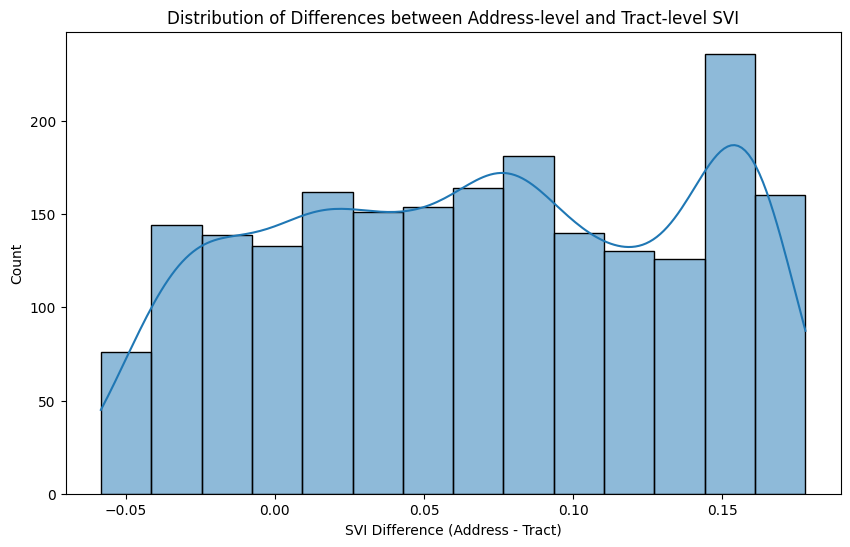

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate summary statistics
summary_stats = address_df_with_both_svi['svi_difference'].describe()
print("\nSummary statistics of SVI difference:")
print(summary_stats)

# Create a histogram of the SVI differences
plt.figure(figsize=(10, 6))
sns.histplot(address_df_with_both_svi['svi_difference'], kde=True)
plt.title('Distribution of Differences between Address-level and Tract-level SVI')
plt.xlabel('SVI Difference (Address - Tract)')
plt.ylabel('Count')
plt.show()


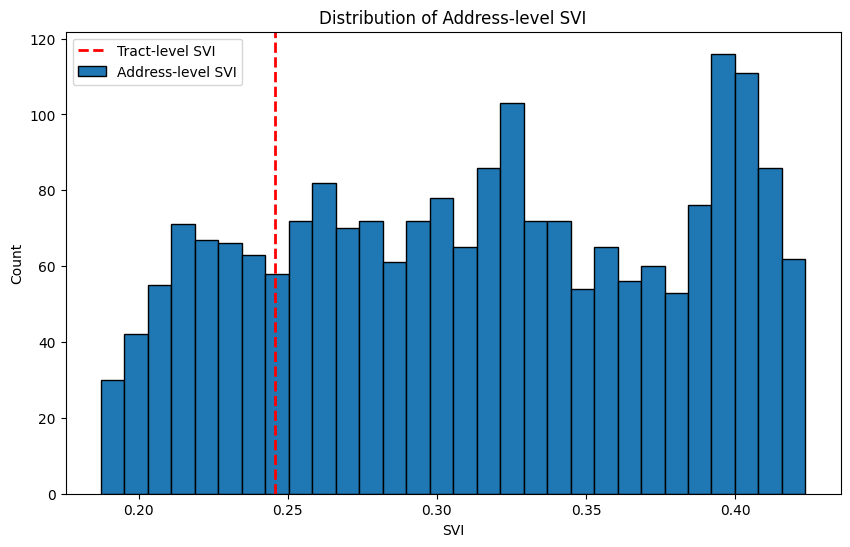

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(address_df_with_both_svi['address_level_svi'], bins=30, edgecolor='black')
plt.axvline(address_df_with_both_svi['tract_level_svi'].iloc[0], color='r', linestyle='dashed', linewidth=2)
plt.title('Distribution of Address-level SVI')
plt.xlabel('SVI')
plt.ylabel('Count')
plt.legend(['Tract-level SVI', 'Address-level SVI'])
plt.show()

### Visualization

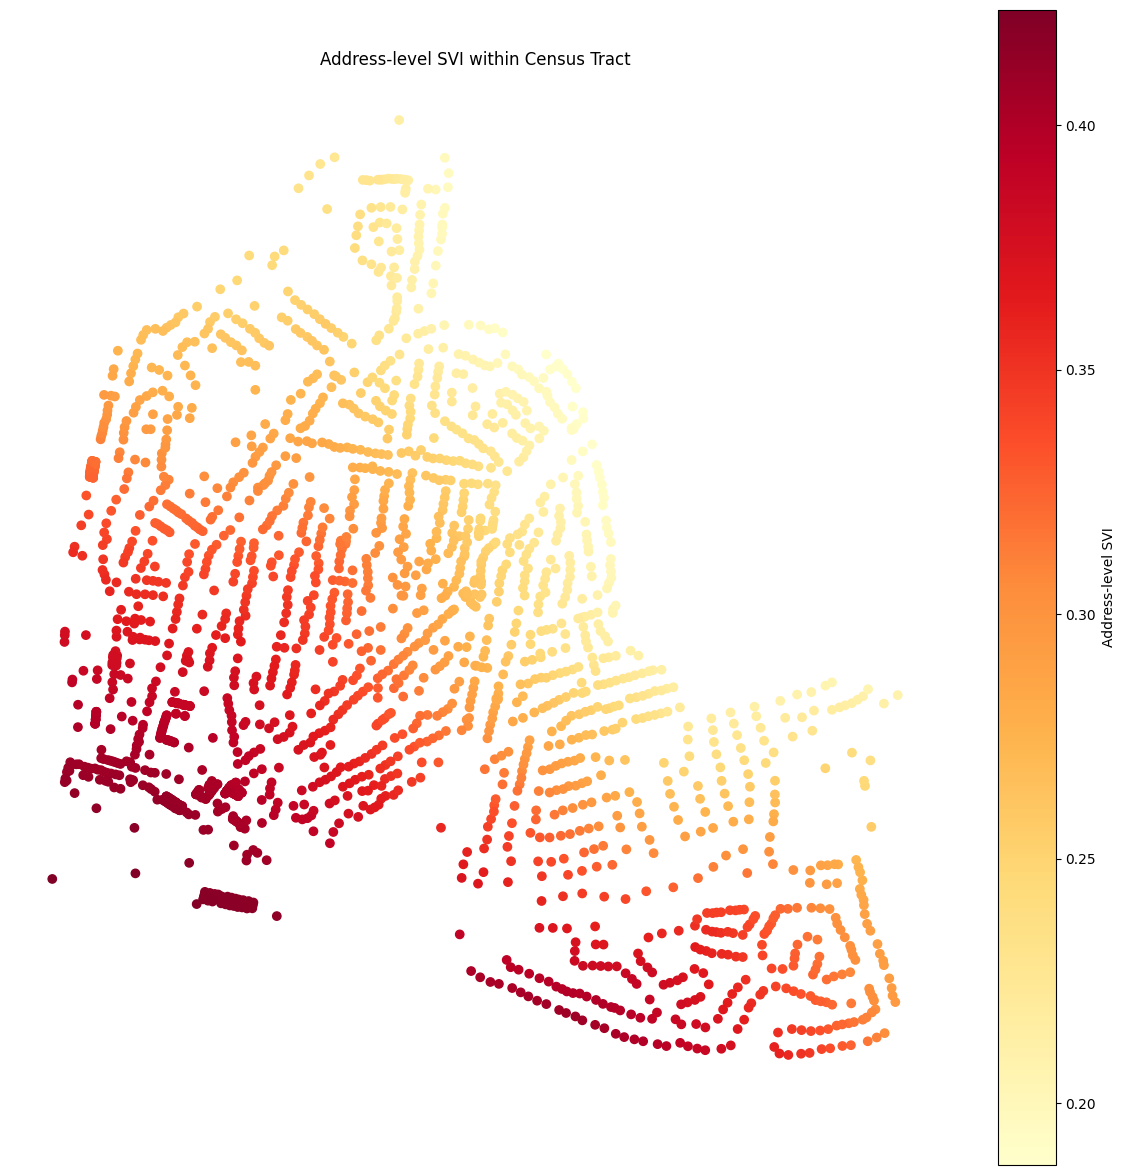

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
address_df_with_both_svi.plot(column='address_level_svi', cmap='YlOrRd',
                              legend=True, ax=ax, legend_kwds={'label': 'Address-level SVI'})
plt.title('Address-level SVI within Census Tract')
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

def visualize_address_svi_with_roads(address_df_with_both_svi, roads_df, target_fips, svi_df):
    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot the roads first with a light gray color
    roads_df.plot(ax=ax, color='lightgray', linewidth=0.5, alpha=0.5)

    # Plot the address points, colored by SVI
    address_df_with_both_svi.plot(column='address_level_svi',
                                  cmap='YlOrRd',
                                  legend=True,
                                  ax=ax,
                                  legend_kwds={'label': 'Address-level SVI'},
                                  markersize=20)

    # Get the target tract and neighboring tracts
    target_tract = svi_df[svi_df['FIPS'] == target_fips].iloc[0]
    neighboring_tracts = svi_df[svi_df.geometry.touches(target_tract.geometry)]
    tracts_to_plot = pd.concat([svi_df[svi_df['FIPS'] == target_fips], neighboring_tracts])

    # Plot tract boundaries
    tracts_to_plot.boundary.plot(ax=ax, color='black', linewidth=1)

    # Highlight the target tract
    target_gdf = gpd.GeoDataFrame([target_tract], geometry='geometry')
    target_gdf.boundary.plot(ax=ax, color='red', linewidth=2)

    # Set the plot extent to focus on the target and neighboring tracts
    ax.set_xlim(tracts_to_plot.total_bounds[0], tracts_to_plot.total_bounds[2])
    ax.set_ylim(tracts_to_plot.total_bounds[1], tracts_to_plot.total_bounds[3])

    plt.title(f'Address-level SVI and Road Network in Census Tract {target_fips}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Usage
visualize_address_svi_with_roads(address_df_with_both_svi, roads_df, target_fips, svi_df)

# FORMULAS

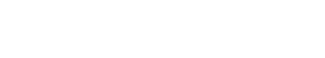

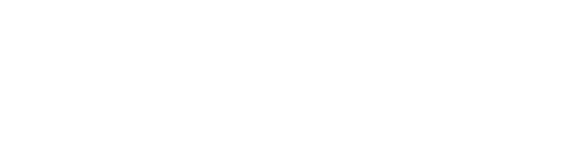

where...

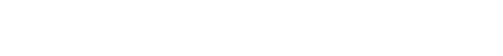

E_c(p,n): The combined inverse elasticity between point p and neighboring area n.

w: The network weight (between 0 and 1). It determines the balance between network and Euclidean distance in the calculation.

λ (lambda): The decay parameter. It controls how quickly the influence decreases with distance.

d_n(p,n): The network distance between point p and the nearest point in neighboring area n.

d_e(p,n): The Euclidean distance between point p and the nearest point in neighboring area n.

e: The mathematical constant e (approximately 2.71828), base of natural logarithms.

s_t: The index value (e.g., SVI) of the target area.

s_n: The index value (e.g., SVI) of the neighboring area n.

β (beta): The exponent for the index difference. It controls how sensitive the calculation is to differences in the index values.

|s_t - s_n|: The absolute difference between the index values of the target and neighboring areas.
